***
# Demo Jupyter Notebook for the DKRZ User Workshop ![DKRZ Logo](https://www.dkrz.de/@@site-logo/dkrz.svg)
# Data Standardization: Simple Tools for Achieving FAIR CF-compliant Data
_Angelika Heil (heil@dkrz.de), 13 October 2022_
***

<div class="alert-info" role="alert">
  <h4 class="alert-heading"><span style="font-family: Arial; font-size:1.4em;color:black;"> README</h4>
 
   In this Jupyter Notebook with a IPython kernel, we use both, python and BASH commands.  <br>  
   To execute BASH commands, put  <br> 
                     (i)   %%bash is in first line of a cell --> entire cell is BASH  <br> 
                     (ii)  !command                          --> individual line is BASH. <br> 
                     (iii) {pyvar} to pass a python variable to BASH<br> </p>
 <p><span style="font-family: Arial; font-size:1.0em;color:black;"> Please also read our theoretical introduction on data standardization on https://gitlab.dkrz.de/dkrz-user-workshop-dm-training1/data-standardization (see Presentation Slides)        <br>   </p> 
  <hr>
</div>

## Step 0: Load the required libraries

In [1]:
import numpy as np
import xarray as xr
import cf_units
import glob, os
from datetime import datetime
import pandas as pd

In [2]:
#-- Customize cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Create working directory
# In case of preexisting working directory, remove all netCDF files in that directory
odir = "wd22_ds"
try:
    os.mkdir(odir)
except FileExistsError:
    print("directory", odir , "already existed! Removing netCDF files...")
    _ = [os.remove(x) for x in glob.glob(odir+"/*.nc")]

directory wd22_ds already existed! Removing netCDF files...


## Step 1: Create a netCDF file with some dummy 3D data
This could be some 2m air temperature model output over South Africa

In [4]:
#-- Create data as numpy arrays
nlat, nlon =  2, 4
lat, lon   =  np.linspace(-34, -22, nlat), np.linspace(16, 32, nlon)      #-- roughly domain of South Africa
ntime      =  3                                                           #-- number of time steps
time       =  np.linspace(0.5, 0.5 + ntime, num = ntime, endpoint=False)  #-- "mid-point" time coordinate values
tas        =  5 + 10 * np.random.randn(ntime, nlat, nlon)                 #-- some fake 2m air temperature data

In [5]:
#-- Store data as xarray dataarray
da         = xr.DataArray(data=tas, dims=["t", "lat", "lon"], coords=[time, lat, lon])

In [6]:
#-- Write out as netCDF
da.rename("tas").to_netcdf(f"{odir}/unstandardized.nc", mode="w", format="NETCDF3_64BIT", 
                            encoding={"lat":{"_FillValue": None}, 
                                      "lon":{"_FillValue": None}, 
                                      "t":{"_FillValue": None},
                                      "tas":{"_FillValue": -999.9}})          
#-- Encoding _FillValue with None suppresses that xarray creates a _FillValue attribute for lat, lon, t. 
#-- _FillValue attributes along with coordinate variables are not CF-compliant.
#-- For tas, we define a _FillValue of -999.9 to represent missing data.

## Step 2: Looking at the unstandardized netCDF file

### (2a) Look at unstandardized netCDF file with NCO and CDO

In [7]:
print("\n", "=" * 10, " unstandardized netCDF dummy file: the netCDF header   ", "=" * 10)
#-- -h option means that only the so-called "netCDF header" is shown, and not the data
!ncdump -h {odir}/unstandardized.nc    

print("\n", "=" * 10, " unstandardized netCDF dummy file: CDO short info      ", "=" * 10)
#--  cdo sinfo gives short overview of how the file is structured
!cdo -s sinfo {odir}/unstandardized.nc


 ==========  unstandardized netCDF dummy file: the netCDF header    ==========
netcdf unstandardized {
dimensions:
	t = 3 ;
	lat = 2 ;
	lon = 4 ;
variables:
	double t(t) ;
	double lat(lat) ;
	double lon(lon) ;
	double tas(t, lat, lon) ;
		tas:_FillValue = -999.9 ;
}



 ==========  unstandardized netCDF dummy file: CDO short info       ==========


   File format : NetCDF2
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter ID
     1 : unknown  unknown  c instant       3   1         8   1  F64  : -1            
   Grid coordinates :
     1 : generic                  : points=8 (4x2)
                              lon : 16 to 32 by 5.333333 
                              lat : -34 to -22 by 12 
   Vertical coordinates :
     1 : generic                  : levels=3
                                t : 0.5 to 2.5 by 1 


<span style="color:red">This unstandardized file has no metadata describing the data.<br>
    It remains unclear what the variable _var_ represents, and what the dimensions and the units are.<br>
    Also note: CDO interprets _t_ as vertical coordinates while it was meant to be time.</span>

### (2b) Check CF compliance

**Run the CF checker _cfchecks_ on the unstandardized netCDF file**

In [8]:
!cfchecks {odir}/unstandardized.nc

CHECKING NetCDF FILE: wd22_ds/unstandardized.nc


Using CF Checker Version 4.1.0
Checking against CF Version CF-1.8
Using Standard Name Table Version 79 (2022-03-19T15:25:54Z)
Using Area Type Table Version 10 (23 June 2020)
Using Standardized Region Name Table Version 4 (18 December 2018)

WARN: (2.6.1): No 'Conventions' attribute present

------------------
Checking variable: t
------------------
WARN: (3): No standard_name or long_name attribute specified
WARN: (3.1): units attribute should be present

------------------
Checking variable: lat
------------------
WARN: (3): No standard_name or long_name attribute specified
WARN: (3.1): units attribute should be present

------------------
Checking variable: lon
------------------
WARN: (3): No standard_name or long_name attribute specified
WARN: (3.1): units attribute should be present

------------------
Checking variable: tas
------------------
WARN: (3): No standard_name or long_name attribute specified
INFO: (3.1): No units attribute set.  Please consider adding a units attribute

<span style="color:red">In a completely unstandardized netCDF file, the CF checker tool output is misleading.<br> 
    0 ERRORS detected does not mean that the file conforms with the CF conventions. Please carefully look at the WARNINGS!<br> 
    The global attribute _Conventions_ must be specified in a netCDF-CF header.<br>
    Principally, if a standard name exists for a variable, then the standard name and its unit should be added as variable attribute.<br>
    If no CF standard name exists, then it is highly recommended to add a unit and a user-defined _long_name_.<br>
</span>

### (2c) Plot the data in the unstandardized netCDF file with xarray

**Open the data and plot an overview of the file content**

In [9]:
da = xr.open_dataset(f"{odir}/unstandardized.nc")
da

<xarray.Dataset>
Dimensions:  (t: 3, lat: 2, lon: 4)
Coordinates:
  * t        (t) float64 0.5 1.5 2.5
  * lat      (lat) float64 -34.0 -22.0
  * lon      (lon) float64 16.0 21.33 26.67 32.0
Data variables:
    tas      (t, lat, lon) float64 ...

**Plot the data (first "timestep" t)**

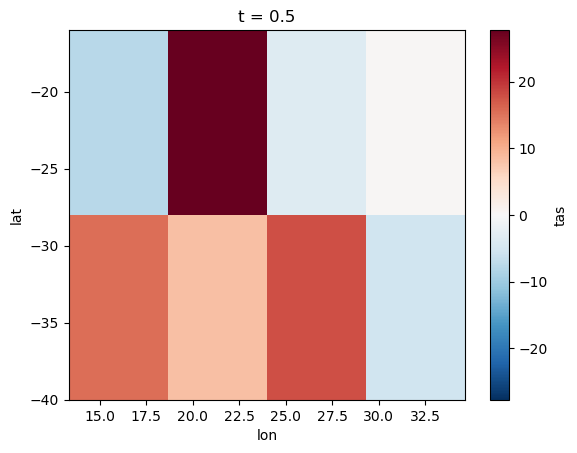

In [10]:
da.tas.isel(t=0).plot();

<span style="color:red">From an unstandardized file, insufficient labels are added to the plot... </span>

## Step 3: Let's create a netCDF file with a minimalistic standardization

### (3a) Define some minimal metadata

**Where to find out the correct metadata to describe the variables?** <br>
It is best practice to add a CF standard name as attribute to each variable. <br>
A list of all CF standard names is provided at https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html<br>
If there is no standard name for your variable, add a user-defined long_name attribute instead.

***
***
  ***How to work with the "canonical units" specified in the CF standard name table?*** <br>
  *–––––––––––––––––––––––&emsp;&emsp; Example  &emsp;&emsp;    –––––––––––––––––––––––* <br>

**(A) How to find out Udunits2-compatible units for *K*?** <br>
* The CF standard name of the tas variable is *air_temperature*; the corresponding canonical units is *K* (i.e. Kelvin).
* Canonical units means that you can also use another units, provided that it is Udunits2-compatible.
* Udunits2 is the Unidata units library (https://github.com/Unidata/UDUNITS-2). It is included in the _cf_units_ library imported in Step 0.

In [11]:
#-- We first check in general if "degC" is a valid Udunits2 units
tarun="degC"          #-- target unit
print("Is \""+tarun+"\" a valid Udunits2 unit? ",  cf_units.Unit(tarun).is_udunits())
#tarun="°c"; #print("Is "+tarun+" a valid Udunits2 unit? ",  cf_units.Unit(tarun).is_udunits()) #==> will raise a ValueError

Is "degC" a valid Udunits2 unit?  True


In [12]:
#-- We then check if "degC" is Udunits2-compatible to the canonical units K
tarun="degC"          #-- target units
canun="K"             #-- canonical units
print("Is \""+tarun+"\" a Udunits2-compatible units to \""+canun+"\"? ",  cf_units.Unit(canun).is_convertible(cf_units.Unit(tarun)))
#--Non-compatible units will raise a ValueError

Is "degC" a Udunits2-compatible units to "K"?  True


**(B) How to find out CF-compliant units for the *time* coordinate variable?** <br>
* The CF standard name of the time coordinate variable is *time*; the corresponding canonical units is *s* (i.e. seconds).<br>
* We want the corresponding units to be _days since 2000-01-01_, i.e. a relative time axis with days as increment.<br>
 ***this is a bit special CF feature, but still easy to check:***
  

In [13]:
#-- We first check 
tarun="days";canun="s"
print("Is \'"+tarun+"\' a Udunits2-compatible units to \'"+canun+"\'? ",  cf_units.Unit(canun).is_convertible(cf_units.Unit(tarun)))
#-- Alternatively, we could check if "days" is a Udunits2-compatible units for time:
print("Is \'"+tarun+"\' a valid Udunits2 time unit? ", cf_units.Unit(tarun).is_time())
#-- What about "days since 2000-01-01"? ..we have to check if this is a Udunits2 valid reference time....
print("Is \'"+tarun+" since 2000-01-01' a a valid Udunits2 time reference? ",
      cf_units.Unit(tarun+" since 2000-01-01").is_time_reference())

Is 'days' a Udunits2-compatible units to 's'?  True
Is 'days' a valid Udunits2 time unit?  True
Is 'days since 2000-01-01' a a valid Udunits2 time reference?  True


In [14]:
#-- With a relative time axis, the calendar should be specified. 
print("What are permissible entries for the time attribute 'calendar'?: \n", cf_units.CALENDARS)
#-- A _standard_ calendar is appropriate for the dummy data.

What are permissible entries for the time attribute 'calendar'?: 
 ['standard', 'gregorian', 'proleptic_gregorian', 'noleap', 'julian', 'all_leap', '365_day', '366_day', '360_day']


***

**Define minimal metadata**

In [15]:
#-- (i)  CF mandatory global attribute Conventions = "CF-X.X"
glo_Con = "CF-1.8"                #-- here we choose CF-1.8 which is the latest version supported 
                                  #   by the CF compliance checker 
#-- (ii) Variable attributes
lat_stn = "latitude"              #-- CF standard name of latitude coordinate variable
lat_uni = "degrees_north"         #-- Units compatible with the CF standard name latitude
lon_stn = "longitude"
lon_uni = "degrees_east"
tim_stn = "time"
tim_uni = "days since 2000-01-01"
tim_cal = "standard"
tas_stn = "air_temperature"
tas_uni = "degC"

### (3b) Add the metadata with NCO

Note: _In the default Levante environment, it would be necessary to load the NCO module with `module load nco`_

In [16]:
#-- Rename t into time with NCO rename variable/dimension (-v/-d) old,new.
#-- This is just nice to have so that CDO correctly inteprets time dimension.
!ncrename -O -v t,time -d t,time {odir}/unstandardized.nc {odir}/tmp.nc 
#-- Note: due to some NCO bug https://github.com/Unidata/netcdf-c/issues/597, 
#   this only works with netCDF3, and not netCDF4.
#  After renaming, we convert the file to netCDF4 classic:
!ncks --fl_fmt=netcdf4_classic {odir}/tmp.nc {odir}/mininal_standardized_nco.nc; rm  {odir}/tmp.nc 

#-- Add attributes with NCO's ncatted, passing python variable to BASH with {pyvar}   
#-- (i) Add global attributes
!ncatted -O -a Conventions,global,c,c,"{glo_Con}" {odir}/mininal_standardized_nco.nc
#-- (ii) Add attributes to the variables
!ncatted -O  -a standard_name,lat,c,c,"{lat_stn}" -a units,lat,c,c,"{lat_uni}" \
             -a standard_name,lon,c,c,"{lon_stn}" -a units,lon,c,c,"{lon_uni}" \
             -a standard_name,time,c,c,"{tim_stn}" -a units,time,c,c,"{tim_uni}" \
             -a calendar,time,c,c,"{tim_cal}" \
             -a standard_name,tas,c,c,"{tas_stn}" -a units,tas,c,c,"{tas_uni}" \
             {odir}/mininal_standardized_nco.nc 

### (3c) Standardize data with xarray

**This python code does the same as the NCO commands above**<br>

In [17]:
ds = xr.open_dataset(f"{odir}/unstandardized.nc")
ds_min = ds.rename({"t": "time"})

In [18]:
ds_min.attrs['Conventions'] = glo_Con

ds_min["lat"].attrs  = { "standard_name": lat_stn, "units": lat_uni } 
ds_min["lon"].attrs  = { "standard_name": lon_stn, "units": lon_uni }
ds_min["time"].attrs = { "standard_name": tim_stn, "units": tim_uni, "calendar": tim_cal }
ds_min["tas"].attrs  = { "standard_name": tas_stn, "units": tas_uni }

In [19]:
ds_min.to_netcdf(f"{odir}/mininal_standardized_xr.nc",
                 mode="w", 
                 format="NETCDF4_CLASSIC", 
                 encoding=
                 {
                     "lat":{"_FillValue": None},
                     "lon":{"_FillValue": None},
                     "time":{"_FillValue": None},
                 })  

## Step 4: Now let's look at the minimally standardized netCDF file

### (4a) Look at the netCDF file with NCO and CDO

In [20]:
print("\n", "=" * 10, " minimally standardized netCDF dummy file: the netCDF header ", "=" * 10)
!ncdump -h {odir}/mininal_standardized_nco.nc

print("\n", "=" * 10, " minimally standardized netCDF dummy file: CDO short info ", "=" * 10)
!cdo -s sinfo {odir}/mininal_standardized_nco.nc


 ==========  minimally standardized netCDF dummy file: the netCDF header  ==========
netcdf mininal_standardized_nco {
dimensions:
	lat = 2 ;
	lon = 4 ;
	time = 3 ;
variables:
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;
	double tas(time, lat, lon) ;
		tas:_FillValue = -999.9 ;
		tas:standard_name = "air_temperature" ;
		tas:units = "degC" ;
	double time(time) ;
		time:standard_name = "time" ;
		time:units = "days since 2000-01-01" ;
		time:calendar = "standard" ;

// global attributes:
		:NCO = "netCDF Operators version 5.1.0 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)" ;
		:Conventions = "CF-1.8" ;
		:history = "Mon Oct 24 17:44:14 2022: ncatted -O -a standard_name,lat,c,c,latitude -a units,lat,c,c,degrees_north -a standard_name,lon,c,c,longitude -a units,lon,c,c,degrees_east -a standard_name,time,c,c,time -a units,time,c,c,days since 20


 ==========  minimally standardized netCDF dummy file: CDO short info  ==========


   File format : NetCDF4 classic
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter ID
     1 : unknown  unknown  v instant       1   1         8   1  F64  : -1            
   Grid coordinates :
     1 : lonlat                   : points=8 (4x2)
                              lon : 16 to 32 by 5.333333 degrees_east
                              lat : -34 to -22 by 12 degrees_north
   Vertical coordinates :
     1 : surface                  : levels=1
   Time coordinate :
                             time : 3 steps
     RefTime =  2000-01-01 00:00:00  Units = days  Calendar = standard
  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss
  2000-01-01 12:00:00  2000-01-02 12:00:00  2000-01-03 12:00:00


### (4b) Check CF compliance

**Run the CF checker _cfchecks_ on the minimally standardized netCDF files**

In [21]:
print("\n", "=" * 10,
      "    NCO minimally standardized netCDF dummy file: CF checker summary    ",
      "=" * 10
     )
!cfchecks {odir}/mininal_standardized_nco.nc|tail -3          

print("\n", "=" * 10,
      " xarray minimally standardized netCDF dummy file: CF checker summary    ",
      "=" * 10
     )
!cfchecks {odir}/mininal_standardized_xr.nc|tail -3  


 ==========     NCO minimally standardized netCDF dummy file: CF checker summary     ==========


ERRORS detected: 0
WARNINGS given: 0
INFORMATION messages: 0



 ==========  xarray minimally standardized netCDF dummy file: CF checker summary     ==========


ERRORS detected: 0
WARNINGS given: 0
INFORMATION messages: 0


<span style="color:red">The CF checker has nothing to complain about the minimally standardized files (created with either NCO or xarray) </span>

### (4c) Plot the data in the minimally standardized netCDF file with xarray


 ==========  xarray single plot     ==========


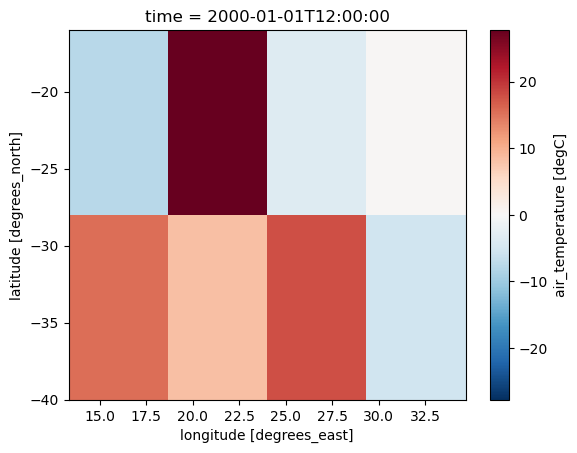

In [22]:
da  = xr.open_dataset(f"{odir}/mininal_standardized_nco.nc")
print("\n", "=" * 10, " xarray single plot    ", "=" * 10)
fig = da.tas.isel(time=0).plot();


 ==========  xarray multipanel plot     ==========


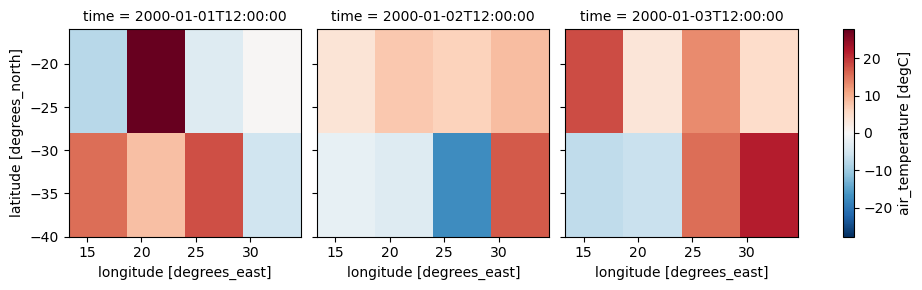

In [23]:
print("\n", "=" * 10, " xarray multipanel plot    ", "=" * 10)
fig = da.tas.plot(x="lon", y="lat", col="time", col_wrap=3); #-- make a multipanel plot with 3 columns

#-- In faceted plots, xarray only prints the variable names as x and y axis labels. 
#-- You can use the standard_name and units attribute as follows: 
fig.set_axis_labels(da.lon.standard_name+" ["+da.lon.units+"]");   #-- adds an xlabel to each subplot
#-- If you prefer a single central xlabel to all subplots; please uncomment: 
#for i, ax in enumerate(fig.axes.flat):
#    #-- remove the xlabels
#    ax.set_xlabel("");  
#fig.axes.flat[1].set(xlabel=da.lon.standard_name+" ["+da.lon.units+"]");


## <br>Step 5: Let's "pimp" the netCDF file towards the ATMODAT Standard

_For more on the ATMODAT Standard, please see: <br>
Ganske, Anette; Kraft, Angelina; Kaiser, Amandine; Heydebreck, Daniel; Lammert, Andrea; Höck, Heinke; Thiemann, Hannes; Voss, Vivien; Grawe, David; Leitl, Bernd; Schlünzen, K. Heinke; Kretzschmar, Jan; Quaas, Johannes (2021). ATMODAT Standard (v3.0). World Data Center for Climate (WDCC) at DKRZ. https://doi.org/10.35095/WDCC/atmodat_standard_en_v3_0_

**Define some essential ATMODAT global metadata**

In [24]:
#-- Complement the global Conventions attribute with ATMODAT standard.
add2Conventions="ATMODAT-3.0"

#-- A meaningful title describing the data, similar to the title in a paper publication.
title="Fake model data of 2m air temperature over South Africa"

#-- The name of the institution principally responsible for originating this data.
institution="German Climate Computing Center, Hamburg, Germany"

#-- If available, institute's ROR identifier, see https://ror.org/.
institution_id="https://ror.org/03ztgj037"

#-- Contact person or point and contact details (free form).
#-- This does not need to be the creator of the data, but rather contact details that are valid in long-term.
#-- For persons, it is recommended to add e.g. their ORCID, see https://orcid.org/
contact="Data Management, data@dkrz.de, German Climate Computing Center, Hamburg, Germany"

#-- Person who created the dataset. The full name and ORCID should be included.
creator="Angelika Heil, heil@dkrz.de, https://orcid.org/0000-0002-8768-5027"

#-- Provide the name of a commonly known license (see also SPDX list of licenses: https://spdx.org/licenses/).
#-- It is recommended to use the SPDX short identifier.
#-- CC-BY-4.0 is the most commonly used license for research data publications.
license="CC-BY-4.0"

#-- Provide details on how the data were produced. In case of model data, mention the model components.
source="Fake data created with numpy random function"

#-- Provide a summary; for details read this summary text.
summary="Here comes a paragraph describing the dataset, analogous to an abstract for a paper. \
It is recommended to include citations (e.g. to literature describing how the data were produced \
or how they were evaluated). \
Also links to websites can be included. The reference list should be included in the \
references global attribute. \
Example: Using sea level pressure distributions from the NCEP/NCAR Reanalysis 1 \
(Kalnay et al., 1996), downloaded from \
https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html \
(last accessed October 7, 2022), ......"

#-- Provide a reference list.
references="Kalnay et al. (1996), https://doi.org/10.1175/1520-0477(1996)077<0437:TNYRP>2.0.CO;2\
; XY et al. (YYYY)....."

#-- It is recommended to assign a version identiﬁer to a data product.
product_version="v0"

#-- Add a creation date in YYYY-MM-DDThh:mm:ss<zone> ISO 8601:2004 extended format.
creation_date=datetime.now().strftime("%Y-%m-%dT%H:%M:%S") + "Z"

#-- Add an audit trail (history) for modifications to the original data.
#-- NCO and CDO automatically appends history entries, while xarray does not. 
#-- In the latter case, it would be optimal to manually add a summary of the xarray operations
#-- applied upon the data. However, it already helps to include the name of the script used.
add2history=creation_date + ": Data standardization with Simple_Data_Standardization.ipynb"


#-- Add some keywords describing your data, using commata to separate them.
#-- This is particularly helpful for the findability of your data.
#-- Data repositories frequently display the netCDF file headers and search machines will look in them for keywords.
#-- Please use keywords that belong to an existing controlled vocabulary. 
#-- For Earth Sciences, the GCMD Science Keyword Compendium is a good place to look for (see https://gcmd.earthdata.nasa.gov/KeywordViewer/).
#-- Please note that it is common practice to provide the full path of a GCMD keyword (see example).
#-- You can also convert the CF standard_name into a GCMD keywords: https://erddap.ifremer.fr/erddap/convert/keywords.html.
#-- If your data have a spatial reference (e.g. Baltic Region or Indian Ocean), please look if there is a corresponding keyword in https://www.geonames.org/. 
keywords="Earth Science > Atmosphere > Atmospheric Temperature > Surface Air Temperature, South Africa, fake data"

#-- Add the name of the keyword compendium from which the keywords originate. Specify None if the keyword is not from a controlled vocabulary.
keywords_vocabulary="GCMD, geonames, None" 


#-- Add some comment that might be helpful to better use the data
comment="The data were created in the framework of the 2022 DKRZ user workshop. They are solely for test purposes."

#-- In case you intend to publish your data via the WDCC, please add the following global attributes.
#publisher_name="World Data Center for Climate (WDCC) at DKRZ"
#publisher_url="https://www.wdc-climate.de"
#-- The website will be created by the WDCC curators
#metadata_link="https://www.wdc-climate.de/ui/entry?acronym=YYYYYYYYYYY"

### (5a) Improve the FAIRness using NCO

**Let's add the global metadata with NCO**

In [25]:
!ncatted -O -a Conventions,global,a,c," {add2Conventions}" \
            -a history,global,a,c,"\n {add2history}" \
            -a title,global,c,c,"{title}" \
            -a institution,global,c,c,"{institution}" \
            -a institution_id,global,c,c,"{institution_id}" \
            -a creator,global,c,c,"{creator}" \
            -a contact,global,c,c,"{contact}" \
            -a license,global,c,c,"{license}" \
            -a source,global,c,c,"{source}" \
            -a summary,global,c,c,"{summary}" \
            -a references,global,c,c,"{references}" \
            -a product_version,global,c,c,"{product_version}" \
            -a creation_date,global,c,c,"{creation_date}" \
            -a keywords,global,c,c,"{keywords}" \
            -a keywords_vocabulary,global,c,c,"{keywords_vocabulary}" \
            -a comment,global,c,c,"{comment}" \
    {odir}/mininal_standardized_nco.nc {odir}/ATMODAT_standardized_nco.nc 

**Add some "Nice-to-haves" for more FAIRness with NCO** <br>
* Add auxillary coordinate variable to specify for which height the variable tas is representative
* Add bounds to the time coordinate variable

In [26]:
#-- In our case, we want the 2m air temperature.
#-- The height:positive = "up" is to avoid that the CDOs raise a warning
!ncap2 -o {odir}/ATMODAT_standardized_nco.nc -O -s "height=2.0" {odir}/ATMODAT_standardized_nco.nc
!ncap2 -o {odir}/ATMODAT_standardized_nco.nc -O -s 'defdim("nv",2);time_bnds=make_bounds(time,$nv);'  \
            {odir}/ATMODAT_standardized_nco.nc
#-- Note that the NCO function make_bounds adds attributes to the time_bnds variable which is not recommended by CF
#-- We remove all attributes to the time_bnds variable with -a ,time_bnds,d,,
!ncatted -O -a standard_name,height,c,c,"height" -a units,height,c,c,"m" -a positive,height,c,c,"up" \
            -a coordinates,tas,c,c,"height lat lon" -a cell_methods,tas,c,c,"time: maximum" \
            -a bounds,time,c,c,"time_bnds" -a ,time_bnds,d,,  {odir}/ATMODAT_standardized_nco.nc

### (5b) Improve the FAIRness using xarray

In [27]:
ds     = xr.open_dataset(f"{odir}/mininal_standardized_xr.nc")
ds     = ds.assign_coords(height=2)
ds["height"].attrs = {"standard_name": "height", "units": "m", "positive": "up"}

ds.attrs["Conventions"] += " " + add2Conventions
ds.attrs["history"] = add2history
#-- this appends additional global attributes
ds.attrs.update({
                "title": title, 
                "institution": institution,
                "institution_id": institution_id,
                "creator": creator,
                "contact": contact,
                "license": license,
                "source": source,
                "summary": summary,
                "references": references,
                "product_version": product_version,
                "creation_date": creation_date,
                "keywords": keywords,
                "keywords_vocabulary": keywords_vocabulary,
                "comment": comment,
                })

#-- Create and append time bounds
timebnds_s, timebnds_e = ds.time - pd.Timedelta(days=0.5), ds.time + pd.Timedelta(days=0.5)
#-- numpy.ndarray of numpy.float64
timebnds_vals = np.append(timebnds_s.to_numpy()[:,None],
                          timebnds_e.to_numpy()[:,None],
                          1)
#-- Specify time_bnds as xarray.DataArray and then merge.
#   Adding time_bnds to ds via 
#   ds['time_bnds'] = xr.DataArray(data=timebnds_vals, dims=("time", "nv"))
#   will cause the time axis encoding to get lost.
time_bnds = xr.DataArray(data=timebnds_vals, dims=("time", "nv"))
ds = xr.merge([ds, time_bnds.rename("time_bnds")])
ds["time"].attrs["bounds"] = "time_bnds"

#-- Set time:cell_methods
ds["tas"].attrs["cell_methods"] = "time: maximum"

#-- Keep xarray from adding _FillValue and coordinates attributes 
#   where it is not supposed to 
#   (see https://github.com/pydata/xarray/issues/5448 & https://github.com/pydata/xarray/issues/5510)
ds["time"].encoding["_FillValue"] = None
ds["lat"].encoding["_FillValue"] = None
ds["lon"].encoding["_FillValue"] = None
ds["time_bnds"].encoding["coordinates"] = None
ds.time_bnds.encoding.update(ds.time.encoding)    #-- time_bnds have int dtype, time has double. Make both double.
ds["tas"].encoding["coordinates"] = 'height lat lon'
#-- In case that tas has no _FillValue attribute, keep xarray from setting it to NAN when writing the netCDF output
#ds["tas"].encoding["_FillValue"] = None

#ds.info()
ds.to_netcdf(f"{odir}/ATMODAT_standardized_xr.nc", format = "NETCDF4_Classic")


## Step 6: Now let's look at the ATMODAT standardized netCDF file

### (6a) Look at the netCDF file with NCO and CDO

In [28]:
print("\n", "=" * 10, " ATMODAT standardized netCDF dummy file: the netCDF header   ", "=" * 10)
!ncdump -v time,time_bnds {odir}/ATMODAT_standardized_xr.nc  

print("\n", "=" * 10, " ATMODAT netCDF dummy file: CDO short info      ", "=" * 10)
!cdo -s sinfo {odir}/ATMODAT_standardized_xr.nc           


 ==========  ATMODAT standardized netCDF dummy file: the netCDF header    ==========
netcdf ATMODAT_standardized_xr {
dimensions:
	time = 3 ;
	lat = 2 ;
	lon = 4 ;
	nv = 2 ;
variables:
	double time(time) ;
		time:standard_name = "time" ;
		time:bounds = "time_bnds" ;
		time:units = "days since 2000-01-01" ;
		time:calendar = "standard" ;
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;
	double tas(time, lat, lon) ;
		tas:_FillValue = -999.9 ;
		tas:standard_name = "air_temperature" ;
		tas:units = "degC" ;
		tas:cell_methods = "time: maximum" ;
		tas:coordinates = "height lat lon" ;
	int height ;
		height:standard_name = "height" ;
		height:units = "m" ;
		height:positive = "up" ;
	double time_bnds(time, nv) ;

// global attributes:
		:Conventions = "CF-1.8 ATMODAT-3.0" ;
		:history = "2022-10-24T17:44:17Z: Data standardization with Simple_Data_Standardization.ipy


 ==========  ATMODAT netCDF dummy file: CDO short info       ==========


   File format : NetCDF4 classic
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter ID
     1 : unknown  Fake     v instant       1   1         8   1  F64  : -1            
   Grid coordinates :
     1 : lonlat                   : points=8 (4x2)
                              lon : 16 to 32 by 5.333333 degrees_east
                              lat : -34 to -22 by 12 degrees_north
   Vertical coordinates :
     1 : height                   : levels=1  scalar
                           height : 2 m
   Time coordinate :
                             time : 3 steps
     RefTime =  2000-01-01 00:00:00  Units = days  Calendar = standard  Bounds = true
  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss
  2000-01-01 12:00:00  2000-01-02 12:00:00  2000-01-03 12:00:00


### (6b) Evaluate the "pimped" ATMODAT-compliant netCDF files with the atmodat checker
*Notes* <br>
* Run the atmodat checker using the command `run_checks` from BASH terminal.
* Please note that the atmodat checker contains two modules:
    * one that checks the global attributes for compliance with the ATMODAT standard, 
    * and another that performs a standard CF check (building upon the cfchecks library).

**Show usage instructions of the `run_checks`**

In [29]:
!run_checks --help

usage: run_checks [-h] [-v] [-op OPATH] [-cfv CFVERSION] [-check WHATCHECKS]
                  [-s] [-V] [-f FILE | -p PATH | -pnr PATH_NO_RECURSIVE]

Run the AtMoDat checks suits.

optional arguments:
  -h, --help            show this help message and exit
  -v, --verbose         Print output of checkers (longer runtime due to double
                        call of checkers)
  -op OPATH, --opath OPATH
                        Define custom path where checker output shall be
                        written
  -cfv CFVERSION, --cfversion CFVERSION
                        Define custom CF table version against which the file
                        shall be checked. Valid are versions from 1.3 to 1.8.
                        Example: "-cfv 1.6". Default is 'auto'
  -check WHATCHECKS, --whatchecks WHATCHECKS
                        Define if AtMoDat or CF check or both shall be
                        executed. Valid options: AT, CF, both. Example:
                        "-check CF". Defau

**Check a single file: ATMODAT_standardized_xr.nc**

In [30]:
!run_checks -s -f {odir}/ATMODAT_standardized_xr.nc

Running Compliance Checker on the datasets from: ['wd22_ds/ATMODAT_standardized_xr.nc']


2022-10-24 15:44:22.517934 [INFO] :: PYESSV :: Loading vocabularies from /work/bm0021/conda-envs-public/repos/atmodat_data_checker/atmodat_checklib/AtMoDat_CVs/pyessv-archive:


2022-10-24 15:44:22.771747 [INFO] :: PYESSV :: ... loaded: atmodat


--- 3.0355 seconds for checking 1 files---


**Look at the checker output**<br>
By default, the output of the last check will be written to atmodat_checker_output/latest/

In [31]:
print('\n', '=' * 10, ' directory listing of atmodat_checker_output/latest/ ', '=' * 10)
!ls -lrt  atmodat_checker_output/latest/

print('\n', '=' * 10, ' content of short_summary.txt ', '=' * 10)
!cat  atmodat_checker_output/latest/short_summary.txt

print('\n', '=' * 10, ' content of long_summary_recommended.txt ', '=' * 10)
!cat  atmodat_checker_output/latest/long_summary_recommended.csv


 ==========  directory listing of atmodat_checker_output/latest/  ==========
total 11
-rw-r--r--. 1 k204212 bm0021   11 Okt 24 17:44 summary_used_licences.txt
-rw-r--r--. 1 k204212 bm0021  457 Okt 24 17:44 short_summary.txt
-rw-r--r--. 1 k204212 bm0021  861 Okt 24 17:44 long_summary_recommended.csv
-rw-r--r--. 1 k204212 bm0021  544 Okt 24 17:44 long_summary_optional.csv
-rw-r--r--. 1 k204212 bm0021   54 Okt 24 17:44 long_summary_mandatory.csv
drwxr-sr-x. 2 k204212 bm0021 4096 Okt 24 17:44 CF
drwxr-sr-x. 2 k204212 bm0021 4096 Okt 24 17:44 atmodat



 ==========  content of short_summary.txt  ==========
=== Short summary === 
 
ATMODAT Standard Compliance Checker Version: 1.3.2
Checking against: ATMODAT Standard 3.0, CF Version 1.8
Checked at: 2022-10-24T17:44:23
 
Number of checked netCDF files: 1

Mandatory ATMODAT Standard checks passed: 4/4 (0 missing, 0 error(s))
Recommended ATMODAT Standard checks passed: 11/20 (9 missing, 0 error(s))
Optional ATMODAT Standard checks passed: 3/9 (6 missing, 0 error(s))

CF checker errors: 0
CF checker warnings: 0


 ==========  content of long_summary_recommended.txt  ==========













<span style="color:red">The check for the ATMODAT global attributes shows that all mandatory attributes are provided and most of the recommended attribute.<br>
    The CF checker implemented in the run_checks routine has found no error. <br>
    Congrats. The data already have a quite high level of FAIRness!  </span>

**Check the entire directory {odir}**

In [32]:
!run_checks -s -p {odir}/

Running Compliance Checker on the dataset from: wd22_ds/mininal_standardized_nco.nc


2022-10-24 15:44:26.170496 [INFO] :: PYESSV :: Loading vocabularies from /work/bm0021/conda-envs-public/repos/atmodat_data_checker/atmodat_checklib/AtMoDat_CVs/pyessv-archive:
2022-10-24 15:44:26.194886 [INFO] :: PYESSV :: ... loaded: atmodat
Running Compliance Checker on the dataset from: wd22_ds/ATMODAT_standardized_xr.nc
Running Compliance Checker on the dataset from: wd22_ds/ATMODAT_standardized_nco.nc
Running Compliance Checker on the dataset from: wd22_ds/unstandardized.nc
Running Compliance Checker on the dataset from: wd22_ds/mininal_standardized_xr.nc


--- 4.3108 seconds for checking 5 files---


**Look at the checker output**<br>

In [33]:
print('\n', '=' * 10, ' content of short_summary.txt ', '=' * 10)
!cat  atmodat_checker_output/latest/short_summary.txt

print('\n', '=' * 10, ' content of long_summary_mandatory.txt ', '=' * 10)
!cat  atmodat_checker_output/latest/long_summary_mandatory.csv


 ==========  content of short_summary.txt  ==========
=== Short summary === 
 
ATMODAT Standard Compliance Checker Version: 1.3.2
Checking against: ATMODAT Standard 3.0, CF Version 1.8
Checked at: 2022-10-24T17:44:29
 
Number of checked netCDF files: 5

Mandatory ATMODAT Standard checks passed: 12/19 (7 missing, 0 error(s))
Recommended ATMODAT Standard checks passed: 23/99 (76 missing, 0 error(s))
Optional ATMODAT Standard checks passed: 6/45 (39 missing, 0 error(s))

CF checker errors: 0
CF checker warnings: 9


 ==========  content of long_summary_mandatory.txt  ==========















<span style="color:red">The check for the ATMODAT global attributes shows that in the 5 netCDF files checked,
    only 12 of 19 mandatory attributes are fulfilled.<br>
    The CF checker implemented in the run_checks routine has found no error, but 9 warnings which should be looked at. <br>
    For more details, look at the long_summary*.csv files or in the detailed checker report files contained in the subdirectories. <br>
    </span>